<a href="https://colab.research.google.com/github/chobocoding/deeplearning/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# content_path = '/content/cat.jpg'
# style_path = '/content/monet.jpg'

device = "cuda:0"
content_block = 2

### 1. Data preparation

In [ ]:
def preprocess(img_dir): # HxWxC or CxHxW -> BxCxHxW (B=1)
    img = Image.open(img_dir) # 영상 불러오기
    transform = transforms.Compose( [transforms.ToTensor()] )
    img = transform(img).view(-1, 3, img.height, img.width)
    return img # tensor

In [ ]:
def postprocess(tensor):  # BxCxHxW -> HxWxC
    img = tensor.clone()
    img = img.clamp(0, 1)
    img = torch.squeeze(img, dim=0)
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    return img

In [ ]:
content_img = preprocess(content_path).to(device)
style_img = preprocess(style_path).to(device)
generated_img = content_img.clone().requires_grad_().to(device)

### 2. Model preparation

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class VGG_FEATURE(nn.Module):
    def __init__(self):
        super(VGG_FEATURE, self).__init__()
        self.block1 = nn.Sequential(*list(vgg16.features.children())[0:3])
        self.block2 = nn.Sequential(*list(vgg16.features.children())[3:8])
        self.block3 = nn.Sequential(*list(vgg16.features.children())[8:15])
        self.block4 = nn.Sequential(*list(vgg16.features.children())[15:22])
        self.block5 = nn.Sequential(*list(vgg16.features.children())[22:29])
        
    def forward(self,x):
        out1 = self.block1(x)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        out5 = self.block5(out4)

        return out1, out2, out3, out4, out5

In [ ]:
vgg_feature = VGG_FEATURE()
for param in vgg_feature.parameters():
    param.requires_grad = False

vgg_feature = vgg_feature.to(device)

In [ ]:
vgg_feature

### 3. Loss function and optimization method

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1, 2))
        return G

In [ ]:
class GramMSELoss(nn.Module):
    def forward(self, input, target): # input: feature map, target: target gram matrix
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [ ]:
style_target = [GramMatrix()(feature_map).to(device) for feature_map in vgg_feature(style_img)]
content_target = vgg_feature(content_img)[content_block-1]
style_weight = [ 1/(n**2)   for n in [64,128,256,512,512] ] # 사용자 임의 설정

In [ ]:
optimizer = torch.optim.Adam([generated_img], lr=0.01)

### 4. Image generation

In [ ]:
for epoch in range(5000):
    optimizer.zero_grad()
    out = vgg_feature(generated_img)

    ## style loss ##
    style_loss = [GramMSELoss().to(device)(out[i], style_target[i]) * style_weight[i] for i in range(5)]

    ## content loss ##
    content_loss = nn.MSELoss().to(device)(out[content_block-1], content_target)

    ## total loss ##
    total_loss = 10 * sum(style_loss) + torch.mean(content_loss)

    total_loss.backward()
    if epoch % 100 == 0:
        print(total_loss.item())

    optimizer.step()

1313032.0
14492.4013671875
8514.51953125
5725.86279296875
3973.02685546875
2794.420166015625
1997.4608154296875
1462.0341796875
1107.4403076171875
871.6433715820312
712.0714721679688
599.763427734375
518.1470947265625
455.8388366699219
406.2359619140625
376.6585998535156
353.1981506347656
301.90411376953125
370.0857849121094
257.4796142578125
242.96578979492188
324.71331787109375
221.2760467529297
206.21054077148438
192.041259765625
324.1377868652344
177.3944854736328
190.6250457763672
313.5671691894531
167.3893280029297
152.01382446289062
146.56886291503906
139.54649353027344
295.7955017089844
137.60853576660156
130.0223388671875
130.62850952148438
118.76524353027344
162.29122924804688
167.584228515625
114.22567749023438
1496.996826171875
126.81050109863281
131.07293701171875
109.42030334472656
109.90428161621094
98.19574737548828
96.11534118652344
249.58328247070312
92.29035949707031


In [ ]:
generated_img

tensor([[[[ 1.0463,  0.3815,  1.7588,  ...,  0.8923,  0.9568,  0.7184],
          [ 0.1126, -0.0974,  0.8023,  ...,  0.2799, -0.0892,  0.2071],
          [-0.3664, -0.2276,  0.9592,  ...,  0.8878,  0.4971,  0.6724],
          ...,
          [-0.9685, -0.6520, -0.1284,  ...,  0.9369,  0.8797,  0.9516],
          [-0.6925, -0.1504,  0.2904,  ...,  0.2242,  0.7060,  0.5077],
          [-0.6108, -0.1756, -1.1381,  ...,  1.7792,  0.5778,  1.7149]],

         [[ 1.3575, -0.0525, -0.5649,  ..., -0.1836, -0.5308, -0.1744],
          [ 0.9400,  0.2518,  0.3838,  ...,  0.7730,  0.6216,  1.0065],
          [ 0.6158,  0.7575,  0.2199,  ...,  0.5281,  0.4781,  0.4345],
          ...,
          [ 0.1328,  0.3055,  0.2128,  ...,  0.6687,  0.7902,  0.8155],
          [-0.3287, -0.0988, -0.1837,  ...,  0.3650,  0.6479,  0.3381],
          [-0.4839,  0.0115,  0.0953,  ...,  1.0024,  0.7215,  1.7215]],

         [[-0.3283,  0.2913,  1.9381,  ...,  0.7382,  0.9022, -0.3242],
          [ 0.2774,  0.9130,  

In [ ]:
gen_img

array([[[1.        , 1.        , 0.        ],
        [0.38146672, 0.        , 0.29127294],
        [1.        , 0.        , 1.        ],
        ...,
        [0.89225036, 0.        , 0.7381911 ],
        [0.95678407, 0.        , 0.90220535],
        [0.71837217, 0.        , 0.        ]],

       [[0.11258975, 0.9400443 , 0.27735096],
        [0.        , 0.2517887 , 0.91299933],
        [0.8023229 , 0.3838446 , 0.35604396],
        ...,
        [0.2799329 , 0.7730416 , 0.2646482 ],
        [0.        , 0.6216409 , 0.0172719 ],
        [0.20711522, 1.        , 0.01996354]],

       [[0.        , 0.6158038 , 0.        ],
        [0.        , 0.7574698 , 0.40898132],
        [0.9592142 , 0.21991868, 0.        ],
        ...,
        [0.8877644 , 0.5281097 , 0.47318894],
        [0.49711117, 0.47805536, 0.64252335],
        [0.67243576, 0.43450662, 0.59142625]],

       ...,

       [[0.        , 0.13275439, 0.        ],
        [0.        , 0.3055016 , 0.526516  ],
        [0.        , 0

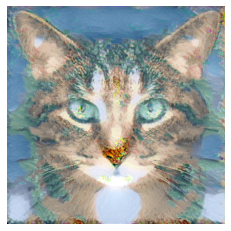

In [ ]:
gen_img = postprocess(generated_img.cpu()).data.numpy()
plt.imshow(gen_img)
plt.axis(False)
plt.show()